In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, MDS
from itertools import product

In [2]:
results_dir = glob.glob('results_*')

In [3]:
def read(fname):
    i = 2
    counter = 0
    n_cells = {}
    connections = {}

    with open(fname + '.txt', 'r') as f:
        lines = f.readlines()
        score = float(lines[0])

        while i < len(lines):
            if lines[i][0] == '#':
                counter += 1

                s, t, m, n = tuple(map(int, lines[i][2:].split(' ')))

                if not s in n_cells:
                    n_cells.update({s: n})
                if not t in n_cells:
                    n_cells.update({t: m})

                txt = [l.split() for l in lines[i+1 : i+1+m]]

                c = np.array(txt, dtype=np.float64).reshape((m, n))
                if c.any(): # any non-zeros
                    connections.update({(s, t): c})

                i += m + 1
            else:
                raise ValueError

    if counter == 0:
        print('No interneuron for', fname)
        return float(lines[0]), NO_INTERNEURON

    if len(connections) == 0:
        print('No non-trivial weight for', fname)
        return float(lines[0]), NO_NON_TRIVIAL_W
    
    return score, n_cells, connections

In [4]:
retinas = []
scores = []
for d in results_dir:
    for i in range(40):
        s, n, c = read('%s/%d'%(d, i))
        retinas.append((n, c))
        scores.append(s)

## Structure

In [5]:
def vis_adjacency(n_cells, connections):
    total_cells = np.sum(list(n_cells.values()))
    
    # Adjacency matrix
    adj = np.zeros((total_cells, total_cells), dtype=np.float64)
    c = 0
    for i, n in n_cells.items():
        r = 0
        ci = n_cells[i]
        
        for j in range(len(n_cells)):
            rj = n_cells[j]
            
            wji = connections.get((i, j))
            if wji is None:
                r += rj
                continue
            
            adj[r:r+rj, c:c+ci] = wji
            
            r += rj
        c += ci
        
    # Laplacian matrix
    laplacian = np.zeros(adj.shape, dtype=np.float64)
    r, c = np.where(adj != 0)
    e = np.zeros(total_cells, dtype=np.float64)
    for i in range(r.shape[0]):
        e *= 0
        e[r[i]] = 1
        e[c[i]] = -1
        w = adj[r[i], c[i]]
        laplacian += w * np.outer(e, e)
    
    # Spectrum
    vals = np.real(np.linalg.eigvals(laplacian))
    i = np.argsort(np.abs(vals))
    vals = vals[i]
    return adj, laplacian, vals[::-1]

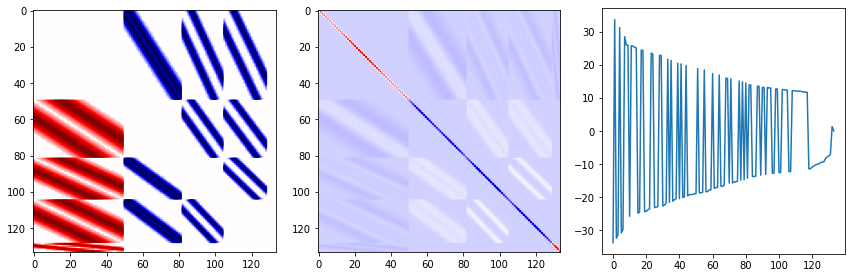

In [6]:
adj, laplacian, spectrum = vis_adjacency(*retinas[0])

fig, ax = plt.subplots(1,3)
fig.set_size_inches(h=4, w=12)
fig.tight_layout()

ax[0].imshow(adj, cmap='seismic', vmin=-1, vmax=1)
ax[1].imshow(laplacian, cmap='seismic')
ax[2].plot(spectrum)

In [7]:
spectra = []
mini = 100
for r in retinas:
    _, _, spectrum = vis_adjacency(*r)
    spectra.append(spectrum)
    if spectrum.shape[0] < mini:
        mini = spectrum.shape[0]
mini

70

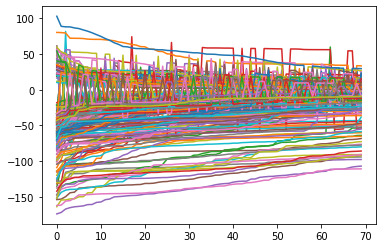

In [8]:
spectra_clipped = np.zeros((len(spectra), mini))
for i, s in enumerate(spectra):
    spectra_clipped[i] = s[:mini]
plt.plot(spectra_clipped.T);

In [9]:
Y_tsne = []
perplexity = list(range(10, 101, 10))
for i, p in enumerate(perplexity):
    tsne = TSNE(n_components=2, perplexity=p)
    Y_tsne.append(tsne.fit_transform(spectra_clipped))

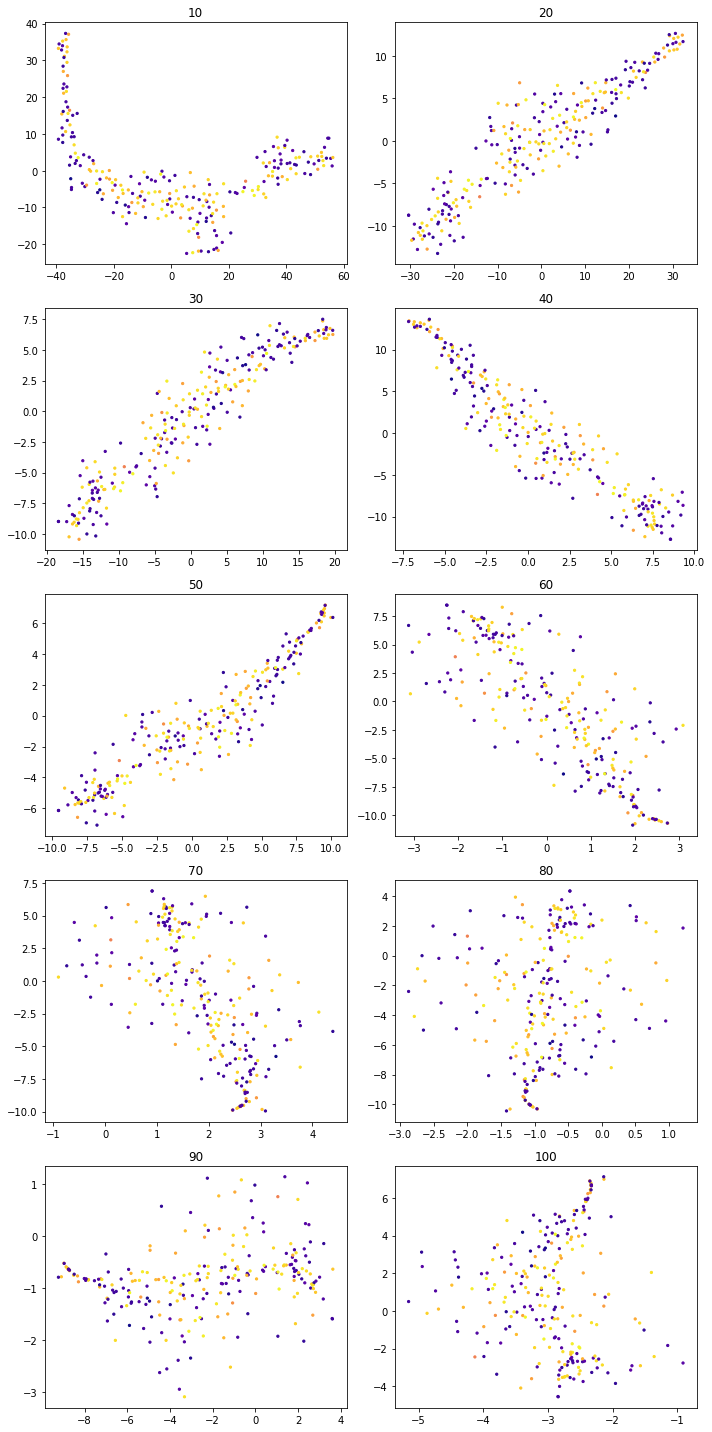

In [14]:
fig, ax = plt.subplots(5, 2)

for i, (p, q) in enumerate(product(range(5), range(2))):
    ax[p, q].scatter(*Y_tsne[i].T, s=5, c=scores, cmap='plasma')
    ax[p, q].set_title(perplexity[i])
    
fig.set_size_inches(h=20, w=10)
fig.tight_layout()

In [11]:
Y_mds = MDS(n_components=2).fit_transform(spectra_clipped)

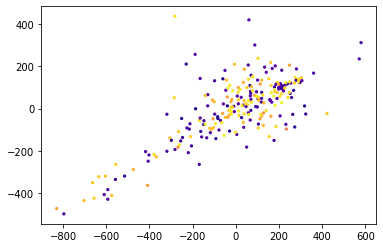

In [18]:
plt.scatter(*Y_mds.T, s=5, c=scores, cmap='plasma')

## Dynamics

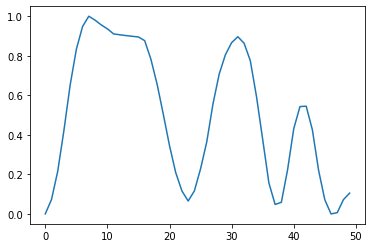

In [67]:
# Generate a random signal of 3 modes
I = np.random.uniform(-0.3, 0.3, 50)
I[4:20] += 0.9
I[27:35] += 0.9
I[40:44] += 0.9
I = np.convolve(I, [0.065, 0.12, 0.175, 0.2, 0.175, 0.12, 0.065], 'same')
I = (I - I.min()) / (I.max() - I.min())
plt.plot(I)

In [18]:
def sim(n_cells, connections):
    tmax = 20
    dt = 0.2
    states = [np.zeros((tmax, n_cells[i])) for i in range(len(n_cells))]

    for t in range(1, tmax):
        for i in range(len(states)):
            aux = - states[i][t-1]

            for j in range(len(states)):
                wji = connections.get((j, i))
                if wji is None:
                    continue

                aux += wji @ expit(states[j][t-1])

            states[i][t] = states[i][t-1] + dt / 2 * aux

            if i == 0:
                states[i][t] += I
    return states

In [19]:
states_superset = []
for i in range(len(retinas)):
    states = sim(*retinas[i])
    states = [expit(state[-1]) for state in states]
    states_superset.append(states)

In [20]:
scores1 = np.zeros((len(states_superset), len(states_superset)))
scores2 = np.zeros((len(states_superset), len(states_superset)))
for i, states1 in enumerate(states_superset):
    for j, states2 in enumerate(states_superset):
        n = len(states1)
        if n != len(states2):
            scores1[i, j] = 1e10
            scores2[i, j] = 1e10
            continue

        for k in range(n):
            scores1[i, j] += dtw(states1[k][-1], states2[k][-1]).normalizedDistance
            scores2[i, j] += dtw(states1[k][-1], states2[k][-1]).distance
        scores1[i, j] /= n
        scores2[i, j] /= n

In [21]:
#scores_cp = scores.copy()

In [22]:
#scores = scores_cp.copy()

In [23]:
scores1[scores1 == 1e10] = scores1[scores1 < 1e10].max() * 1.25
scores2[scores2 == 1e10] = scores2[scores2 < 1e10].max() * 1.25

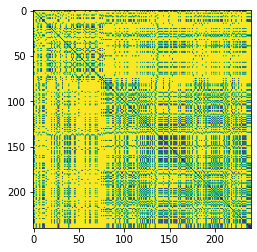

In [24]:
plt.imshow(scores1)

In [25]:
mds1 = MDS(dissimilarity='precomputed').fit_transform(scores1)
mds2 = MDS(dissimilarity='precomputed').fit_transform(scores2)

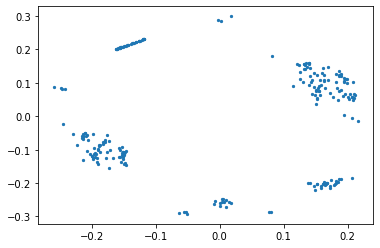

In [26]:
plt.scatter(*mds1.T, s=5)

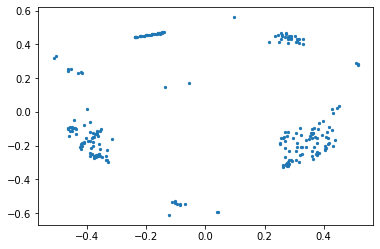

In [27]:
plt.scatter(*mds2.T, s=5)

In [28]:
scores3 = np.zeros((len(states_superset), len(states_superset)))
for i, states1 in enumerate(states_superset):
    for j, states2 in enumerate(states_superset):
        m, n = len(states1) - 1, len(states2) - 1
        
        scores3[i, j] += dtw(states1[0][-1], states2[0][-1]).normalizedDistance
        scores3[i, j] += dtw(states1[-1][-1], states2[-1][-1]).normalizedDistance
        
        for k1 in range(1, m):
            for k2 in range(1, n):
                scores3[i, j] += dtw(states1[k1][-1], states2[k2][-1]).normalizedDistance
        scores1[i, j] /= max(m, n)

In [29]:
mds3 = MDS(dissimilarity='precomputed').fit_transform(scores3)

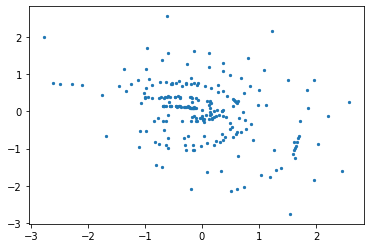

In [30]:
plt.scatter(*mds3.T, s=5)

In [31]:
type1 = [retinas[i] for i in range(len(retinas)) if labels[i] == 1]
type2 = [retinas[i] for i in range(len(retinas)) if (labels[i] == 2) or (labels[i] == 0)]
type3 = [retinas[i] for i in range(len(retinas)) if labels[i] == 3]
assert len(type1) + len(type2) + len(type3) == 800

NameError: name 'labels' is not defined

In [ ]:
c = ['red', 'blue', 'black']
for i in range(1, 4):
    plt.scatter(*mds[labels == i].T, s=5, c=c[i-1], label=i)
plt.legend()

In [ ]:
l = len(type1[2][1].keys())
fig, ax = plt.subplots(l)
# fig.tight_layout(pad=0)
fig.set_size_inches(h=5 * l, w=5)
for i, k in enumerate(type1[0][1].keys()):
    c = type1[2][1][k]
#     if c.shape[0] > c.shape[1]:
#         c = c.T
    
    im = ax[i].imshow(c, cmap='seismic', vmin=-1, vmax=1)
    ax[i].set_title('%d to %d' % (k))

In [ ]:
l = len(type2[0][1].keys())
fig, ax = plt.subplots(l)
fig.set_size_inches(h=5 * l, w=5)
for i, k in enumerate(type2[0][1].keys()):
    c = type2[0][1][k]
#     if c.shape[0] > c.shape[1]:
#         c = c.T
    
    im = ax[i].imshow(c, cmap='seismic', vmin=-1, vmax=1)
    ax[i].set_title('%d to %d' % (k))

In [ ]:
l = len(type3[0][1].keys())
fig, ax = plt.subplots(l)
# fig.tight_layout(pad=0)
fig.set_size_inches(h=5 * l, w=5)
for i, k in enumerate(type3[0][1].keys()):
    c = type3[0][1][k]
#     if c.shape[0] > c.shape[1]:
#         c = c.T
    
    im = ax[i].imshow(c, cmap='seismic', vmin=-1, vmax=1)
    ax[i].set_title('%d to %d' % (k))